In [140]:
%pylab inline --no-import-all
matplotlib.style.use('ggplot')
from joblib import Parallel, delayed
from tqdm import tqdm_notebook as tqdm

Populating the interactive namespace from numpy and matplotlib


# Hoeffding Inequality

In [90]:
def coins_experiments(n_coins, n_flips, n_experiments):
    
    flips = np.random.randint(0, 2, size=(n_experiments, n_coins, n_flips), dtype=bool)
    frequencies = np.apply_along_axis(arr=flips, axis=2, func1d=np.mean)

    fr_1 = frequencies[:, 0]
    fr_min = np.min(frequencies, axis=1)
    fr_rand = np.apply_along_axis(func1d=np.random.choice, arr=frequencies, axis=1)
    
    return np.mean(fr_1), np.mean(fr_min), np.mean(fr_rand)

Benchmark a 1/100 of experiment to approximate full experiment time requirements

In [95]:
%time Parallel(n_jobs=4)(delayed(coins_experiments)(1000, 10, 250) for i in range(4))
pass

CPU times: user 32 ms, sys: 40 ms, total: 72 ms
Wall time: 3.18 s


So full experiment will take about 100x time to run.
Be careful as for sake of computations speed it takes about 1GB of memory just for raw data plus ~1GB for intermediate steps.

In [94]:
nus_list = np.array( Parallel(n_jobs=4)(delayed(coins_experiments)(1000, 10, 25000) for i in range(4)) )
nu_1, nu_min, nu_rand = np.mean(nus_list, axis=0)
print("nu_1 is %f" % nu_1)
print("nu_min is %f" % nu_min)
print("nu_rand is %f" % nu_rand)

nu_1 is 0.502688
nu_min is 0.037824
nu_rand is 0.499984


# Linear regression

In [96]:
from linear_regression import LinearRegression as LR
from perceptron import Perceptron

In [116]:
lr = LR()

In [117]:
X = np.random.normal(size=(100, 1))
y = np.random.normal(loc=0.4, size=(100, 1)) - 3*X
lr.fit(X, y, method='closed')

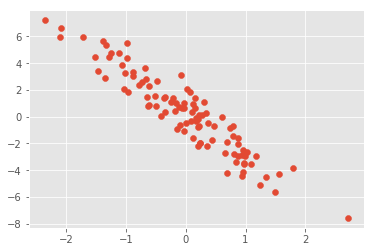

In [118]:
plt.scatter(X, y)

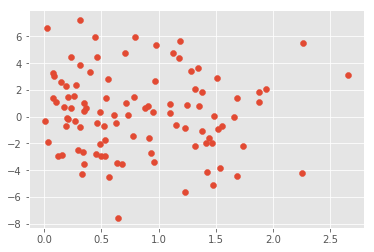

In [119]:
plt.scatter(np.abs(lr.predict(X) - y), y)

In [120]:
lr.r_squared(X, y)

array([ 0.88287122])

In [121]:
def create_dataset(n, w):
    # n: sample size
    # w: boundary line coefs (intercept, slope1, slope2)
    wlen = np.sqrt(np.sum(np.inner(w, w)))
    f = lambda x: np.sign(np.inner(w/wlen, np.concatenate(([1], x))))
    X = np.random.uniform(-1, 1, size=(n, 2))
    y = np.apply_along_axis(f, 1, X)
    return X, y


def line(coefs):
    if coefs[2] > 0:
        x1 = np.array([-1, 1])
        x2 = (lambda x: -(coefs[0] + coefs[1] * x) / coefs[2])(x1)
    elif coefs[1] > 0:
        x2 = np.array([-1, 1])
        x1 = (lambda x: -(coefs[0] + coefs[2] * x) / coefs[1])(x2)
    else:
        x1 = [-1, 1]
        x2 = [-1,-1]
    return (x1, x2)

(-1, 1)

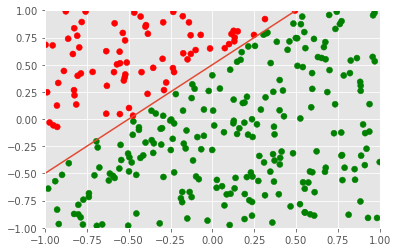

In [122]:
true_coefs = [1, 2, -2]
X, y = create_dataset(300, true_coefs)

plt.scatter(X[:, 0], X[:, 1], c=np.where(y>0, 'green', 'red'))
plt.plot(*line(true_coefs))
plt.xlim(-1, 1)
plt.ylim(-1, 1)

In [123]:
lr.fit(X, y)
yhat = lr.predict(X)

(-1, 1)

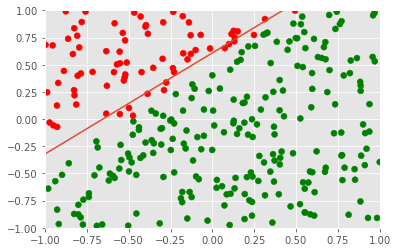

In [124]:
plt.scatter(X[:, 0], X[:, 1], c=np.where(y>0, 'green', 'red'))
plt.plot(*line(lr._coef))
plt.xlim(-1, 1)
plt.ylim(-1, 1)

In [125]:
print("in-sample error: %f" % np.mean(np.sign(yhat).reshape((-1)) != y))

in-sample error: 0.036667


In [151]:
sum_of_errors = 0
sum_of_errors2 = 0

for _ in tqdm(range(1000), desc='progress'):
    lr = LR()
    true_coefs = np.random.uniform(low=-5, high=5, size=(3))
    X, y = create_dataset(100, true_coefs)
    testX, testY = create_dataset(10000, true_coefs)
    lr.fit(X, y)
    yhat = lr.predict(X)
    yhat2 = lr.predict(testX)
    error = np.mean(np.sign(yhat).reshape((-1)) != y)
    error2 = np.mean(np.sign(yhat2).reshape((-1)) != testY)
    sum_of_errors += error
    sum_of_errors2 += error2
    
print("average in-sample error: %f" % (sum_of_errors / 1000))
print("average out-of-sample error: %f" % (sum_of_errors2 / 1000))


average in-sample error: 0.035770
average out-of-sample error: 0.041742
